In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150.0

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as pl

In [3]:
from peerless._search import search
from peerless.data import load_light_curves_for_kic, running_median_trend, load_light_curves

In [107]:
kicid = 10602068
# lcs = load_light_curves_for_kic(kicid)
lcs = load_light_curves(glob.glob("/Users/dfm/peerless/data/*{0}*.fits".format(kicid)), remove_kois=True)

In [108]:
tau = 0.6
noise_scale = 20

time = []
depth = []
depth_ivar = []

for lc in lcs:
    time.append(np.arange(lc.time.min(), lc.time.max(), 0.25 * tau))
    d, ivar = search(tau, time[-1], lc.time, lc.flux - 1.0, 1.0 / lc.ferr**2)
    depth.append(d)
    depth_ivar.append(ivar)
    
time = np.concatenate(time)
depth = np.concatenate(depth)
depth_ivar = np.concatenate(depth_ivar)

In [109]:
s2n = depth * np.sqrt(depth_ivar)
m = depth_ivar > 0.0
noise = np.nan + np.zeros_like(s2n)
noise[m] = running_median_trend(time[m], np.abs(s2n[m]), 15.0)

In [110]:
m = s2n > noise_scale * noise
s2n_thresh = s2n[m]
t0_thresh = time[m]
peaks = []

while len(s2n_thresh):
    i = np.argmax(s2n_thresh)
    t0 = t0_thresh[i]
    peaks.append((t0, s2n_thresh[i]))
    m = np.abs(t0_thresh - t0) > 2*tau
    s2n_thresh = s2n_thresh[m]
    t0_thresh = t0_thresh[m]

In [111]:
peaks

[(830.52460229039389, 941.1079461115288)]

In [112]:
if len(peaks):
    t0 = peaks[0][0] + 0.5*tau
else:
    t0 = time[np.argsort(s2n)[-1]] + 0.5*tau

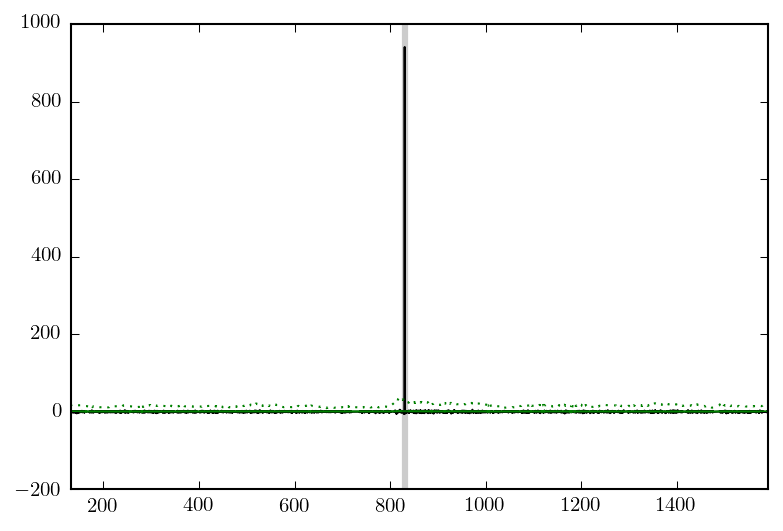

In [113]:
pl.plot(time, s2n, "k")
pl.plot(time, noise, "g")
pl.plot(time, noise_scale*noise, ":g")
pl.gca().axvline(t0, color="k", lw=3, alpha=0.2)
pl.xlim(time.min(), time.max());

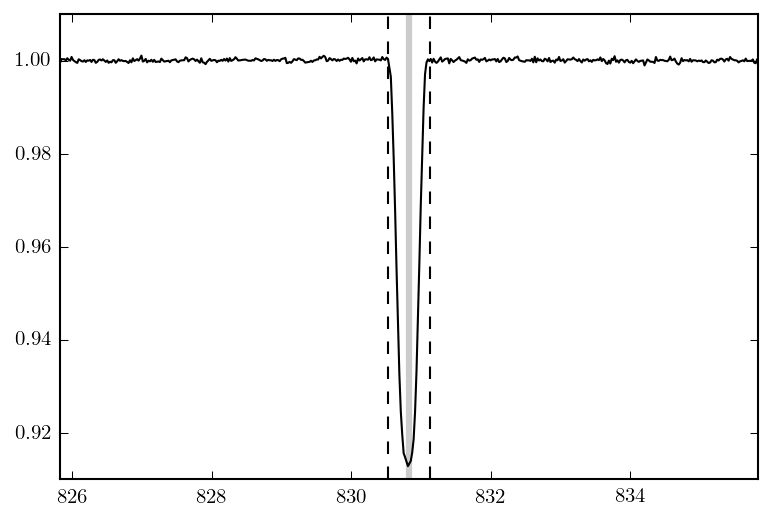

In [114]:
[pl.plot(lc.time, lc.flux, "-k") for lc in lcs]
pl.gca().axvline(t0, color="k", lw=3, alpha=0.2)
pl.gca().axvline(t0 - 0.5*tau, color="k", ls="dashed")
pl.gca().axvline(t0 + 0.5*tau, color="k", ls="dashed")
pl.xlim(t0 - 5, t0 + 5);

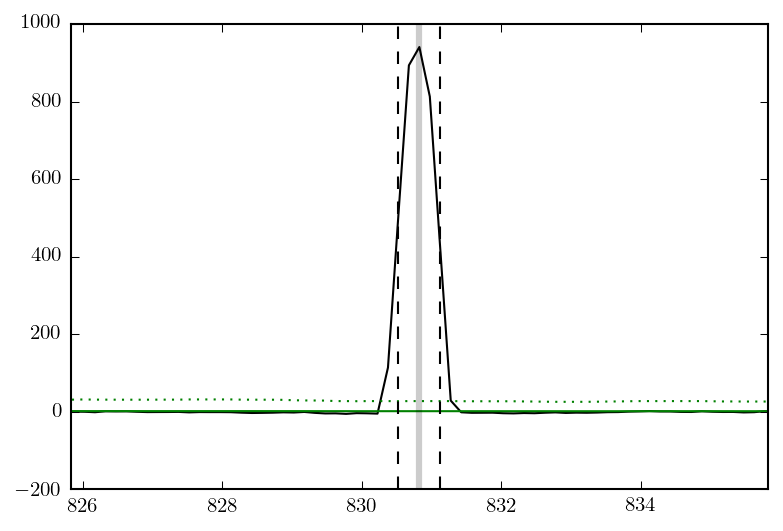

In [115]:
pl.plot(time+0.5*tau, s2n, "k")
pl.plot(time+0.5*tau, noise, "g")
pl.plot(time, noise_scale*noise, ":g")
pl.gca().axvline(t0, color="k", lw=3, alpha=0.2)
pl.gca().axvline(t0 - 0.5*tau, color="k", ls="dashed")
pl.gca().axvline(t0 + 0.5*tau, color="k", ls="dashed")
pl.xlim(t0 - 5, t0 + 5);